In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ECE_PROJECT/

/content/drive/MyDrive/ECE_PROJECT


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content/drive/MyDrive/ECE_PROJECT


## **Downloads Kaggle Dataset**

In [ ]:
!pip install kaggle --upgrade --quiet

ERROR: Operation cancelled by user


In [ ]:
import os
from getpass import getpass

In [ ]:
# os.environ['KAGGLE_USERNAME'] = getpass('Enter KAGGLE_USERNAME secret value: ')
# os.environ['KAGGLE_KEY'] = getpass('Enter KAGGLE_KEY secret value: ')

In [ ]:
# !kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset -p dataset/

In [ ]:
# !unzip dataset/face-expression-recognition-dataset.zip -d dataset/

In [ ]:
# !rm dataset/face-expression-recognition-dataset.zip

## **Data Preprocessing**

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
base_dir = f'{HOME}/dataset/images'
SOURCE_TRAIN_DIR = f'{base_dir}/train'
SOURCE_TEST_DIR = f'{base_dir}/validation'

print(SOURCE_TRAIN_DIR)
print(SOURCE_TEST_DIR)

/content/drive/MyDrive/ECE_PROJECT/dataset/images/train
/content/drive/MyDrive/ECE_PROJECT/dataset/images/validation


In [ ]:
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
raw_data = datasets.ImageFolder(SOURCE_TRAIN_DIR,
                                transform=transform)
print(len(raw_data))
print(raw_data.class_to_idx)

data_loader = DataLoader(raw_data, batch_size=128, shuffle=True)

28821
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
raw_test_data = datasets.ImageFolder(SOURCE_TEST_DIR,
                                transform=transform)
print(len(raw_test_data))
print(raw_test_data.class_to_idx)

test_data_loader = DataLoader(raw_test_data,
                                  batch_size=128, shuffle=True)

7066
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
def convert_to_numpy(data_loader):
  images = []
  labels = []

  for batch in data_loader:
      image, label = batch
      images.append(image)
      labels.append(label)

  images = torch.cat(images, dim=0).numpy()
  labels = torch.cat(labels, dim=0).numpy()

  return images, labels

In [ ]:
train_imgs, train_labels = convert_to_numpy(data_loader)
test_imgs, test_labels = convert_to_numpy(test_data_loader)

In [ ]:
print(train_imgs.shape)
print(train_labels.shape)

print(test_imgs.shape)
print(test_labels.shape)

(28821, 1, 48, 48)
(28821,)
(7066, 1, 48, 48)
(7066,)


In [ ]:
def show_image(images, labels, num_images=6):
  fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
  for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')
  plt.show()

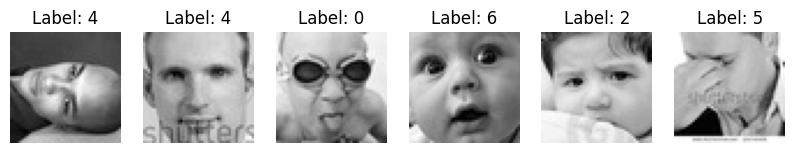

In [ ]:
show_image(train_imgs, train_labels)

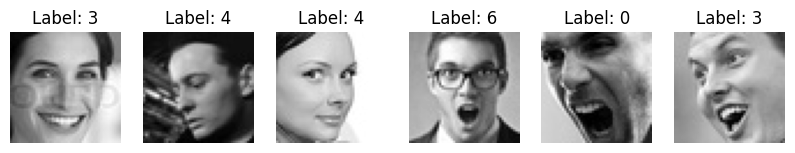

In [ ]:
show_image(test_imgs, test_labels)

In [ ]:
def images_flattened(images):
  return images.reshape(images.shape[0], -1)

train_imgs = images_flattened(train_imgs)
test_imgs = images_flattened(test_imgs)

In [ ]:
print(train_imgs.shape)
print(test_imgs.shape)

(28821, 2304)
(7066, 2304)


In [ ]:
np.save('saved_params/train_images_flattened.npy', train_imgs)
np.save('saved_params/labels.npy', train_labels)

np.save('saved_params/test_imgs_flattened.npy', test_imgs)
np.save('saved_params/test_labels.npy', test_labels)

## **Load Preprocessed Flatten Data**

In [ ]:
images_flattened = np.load('saved_params/images_flattened.npy')
labels = np.load('saved_params/labels.npy')

test_imgs_flattened = np.load('saved_params/test_imgs_flattened.npy')
test_labels = np.load('saved_params/test_labels.npy')

print(images_flattened.shape)
print(labels.shape)

print(test_imgs_flattened.shape)
print(test_labels.shape)

(28821, 2304)
(28821,)
(7066, 2304)
(7066,)


In [ ]:
train_imgs_flattened = np.load('saved_params/train_images_flattened.npy')
test_imgs_flattened = np.load('saved_params/test_imgs_flattened.npy')

train_labels = np.load('saved_params/labels.npy')
test_labels = np.load('saved_params/test_labels.npy')

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_imgs_flattened, train_labels, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(23056, 2304)
(5765, 2304)
(23056,)
(5765,)


## **Scale & Feature Extraction**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)

In [ ]:
print(f"Number of features before PCA: {train_imgs_flattened.shape[1]}")
print(f"Number of features after PCA: {X_train_pca.shape[1]}")

print(f"Explained variance ratio {sum(pca.explained_variance_ratio_)}")

Number of features before PCA: 2304
Number of features after PCA: 257
Explained variance ratio 0.9501149180869106


In [ ]:
test_scaled = scaler.transform(test_imgs_flattened)
test_pca = pca.transform(test_scaled)

In [ ]:
print(X_train_pca.shape)
print(X_valid_pca.shape)
print(test_pca.shape)

(23056, 257)
(5765, 257)
(7066, 257)


In [ ]:
np.savez('saved_params/pca_data_with_label.npz',
         X_train_pca=X_train_pca, X_valid_pca=X_valid_pca, y_train=y_train,
         y_valid=y_valid)

np.savez('saved_params/test_pca_data_with_label.npz', test_pca=test_pca,
         test_labels=test_labels)

***Loading PCA Processed Data***

In [ ]:
data = np.load('saved_params/pca_data_with_label.npz')
X_train_pca = data['X_train_pca']
X_valid_pca = data['X_valid_pca']
y_train = data['y_train']
y_valid = data['y_valid']

test_data = np.load('saved_params/test_pca_data_with_label.npz')
test_pca = test_data['test_pca']
test_labels = test_data['test_labels']

In [ ]:
print(X_train_pca.shape)
print(X_valid_pca.shape)
print(test_pca.shape)

(23056, 257)
(5765, 257)
(7066, 257)


**Train Model With SVM**

In [ ]:
!nvidia-smi

Sun Mar 31 05:38:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.

# API Link https://docs.rapids.ai/api/cuml/stable/api/#regression-and-classification

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.2 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has a Tesla T4 GPU!
We will install the latest stable RAPIDS via pip 24.2.*!  Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.7/464.7 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 537.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 GB 603.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.6/917.6 kB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 14.1 MB/s eta 0:

In [ ]:
import cuml
cuml.__version__

# https://docs.rapids.ai/api/cuml/stable/api/#support-vector-machines

'24.02.00'

In [ ]:
import joblib
from cuml.svm import SVC
from cuml.metrics.accuracy import accuracy_score
from cuml.metrics import confusion_matrix

In [ ]:
clf = SVC(C=10, probability=True)
clf.fit(X_train_pca, y_train)

[W] [05:43:48.921159] Warning: could not fill working set, found only 797 elements
[W] [05:43:49.047715] Warning: could not fill working set, found only 797 elements
[W] [05:43:49.142964] Warning: could not fill working set, found only 797 elements
[W] [05:43:49.208643] Warning: could not fill working set, found only 797 elements
[W] [05:43:49.288260] Warning: could not fill working set, found only 797 elements
[W] [05:43:57.070256] Warning: could not fill working set, found only 796 elements
[W] [05:43:57.135639] Warning: could not fill working set, found only 796 elements
[W] [05:43:57.278447] Warning: could not fill working set, found only 796 elements
[W] [05:43:57.516249] Warning: could not fill working set, found only 796 elements
[W] [05:43:57.724206] Warning: could not fill working set, found only 796 elements
[W] [05:43:57.782619] Warning: could not fill working set, found only 1018 elements
[W] [05:44:05.548770] Warning: could not fill working set, found only 797 elements
[W]

SVC()

In [ ]:
y_pred = clf.predict(X_valid_pca)

accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_valid, y_pred))

Accuracy: 0.43642669916152954
              precision    recall  f1-score   support

           0       0.38      0.20      0.26       805
           1       0.64      0.31      0.42        80
           2       0.39      0.21      0.27       824
           3       0.46      0.77      0.57      1397
           4       0.42      0.34      0.38      1023
           5       0.36      0.32      0.34       998
           6       0.53      0.65      0.58       638

    accuracy                           0.44      5765
   macro avg       0.45      0.40      0.40      5765
weighted avg       0.42      0.44      0.41      5765



In [ ]:
joblib.dump(clf, 'saved_params/cuml_svc_model.joblib')

['saved_params/cuml_svc_model.joblib']

**Load model to evaluate performance**

In [ ]:
import joblib
model = joblib.load('saved_params/cuml_svc_model.joblib')
print(model)

SVC()


In [ ]:
y_test_pred = model.predict(test_pca)

accuracy = accuracy_score(test_labels, y_test_pred)
print(f"Model accuracy: {accuracy:.2f}")

class_report = classification_report(test_labels, y_test_pred)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(test_labels, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

Model accuracy: 0.39
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.40      0.34       960
           1       0.90      0.25      0.39       111
           2       0.31      0.35      0.33      1018
           3       0.52      0.54      0.53      1825
           4       0.53      0.10      0.17      1216
           5       0.27      0.46      0.34      1139
           6       0.71      0.42      0.53       797

    accuracy                           0.39      7066
   macro avg       0.50      0.36      0.37      7066
weighted avg       0.45      0.39      0.38      7066

Confusion Matrix:
[[381   1 129 174  18 237  20]
 [ 24  28  13  18   1  24   3]
 [182   0 358 155  28 260  35]
 [236   0 198 994  23 353  21]
 [193   0 159 275 119 431  39]
 [221   2 151 206  23 520  16]
 [ 74   0 165  80  12 133 333]]
